In [64]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,6e18918b-4ab5-4534-a245-8c68b2e5232b,mixed_function,Transformer,"function_types=['linear', 'quadratic', 'neural...",-1,-1,20,12,8,mixed_function_all_types


In [66]:
task = "mixed_function"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "6e18918b-4ab5-4534-a245-8c68b2e5232b"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

mixed_function_all_types da52891c-0cbe-4724-b4fb-9697204c92f2


100%|██████████| 6/6 [00:00<00:00, 13238.20it/s]


=== Mixed Function Evaluation Results ===

LINEAR Metrics:
  Model: gpt2_embd=256_layer=12_head=8
    Mean Error: [19.20809555053711, 20.79850196838379, 21.898231506347656, 18.058645248413086, 20.72505760192871, 21.03890037536621, 20.808908462524414, 21.062870025634766, 20.498306274414062, 18.936058044433594, 20.26613998413086, 20.26472282409668, 19.9052734375, 21.276050567626953, 20.98685646057129, 20.229740142822266, 21.02693748474121, 21.62390899658203, 20.24695587158203, 20.566600799560547, 20.111690521240234, 21.67218589782715, 21.342309951782227, 20.79829978942871, 20.315046310424805, 19.06993293762207, 20.340930938720703, 20.336965560913086, 20.569751739501953, 19.394432067871094, 20.452985763549805, 20.405986785888672, 19.916955947875977, 19.546539306640625, 20.564687728881836, 20.790027618408203, 21.506521224975586, 19.777904510498047, 19.47847557067871, 19.804847717285156, 21.960107803344727]
    Std Dev: [31.44783592224121, 30.686887741088867, 32.82551574707031, 25.49433326

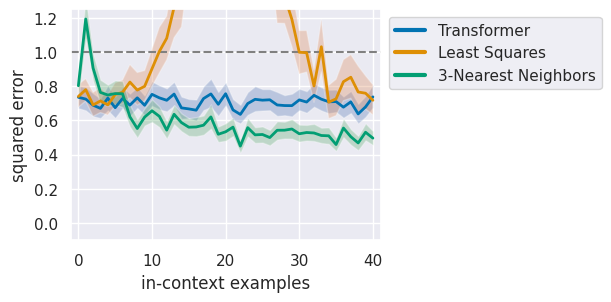

In [32]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

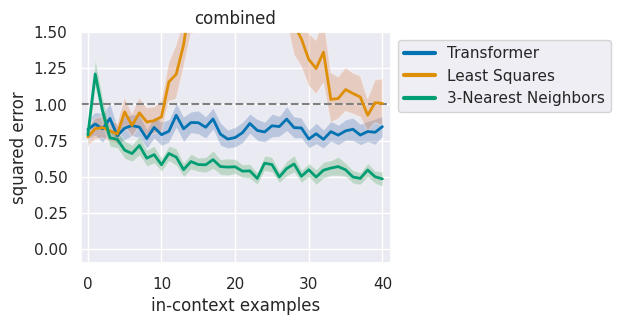

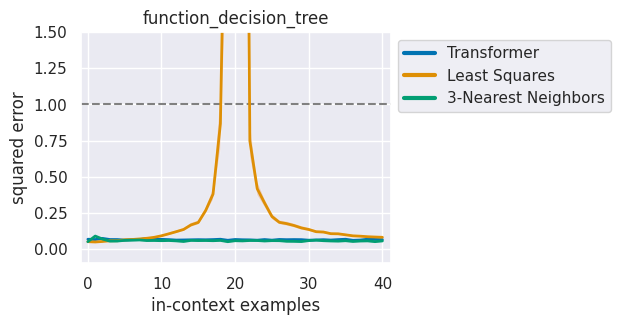

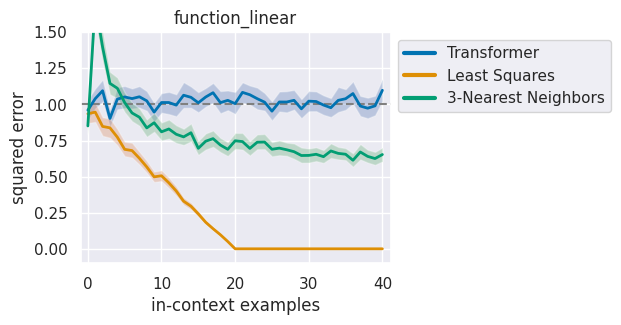

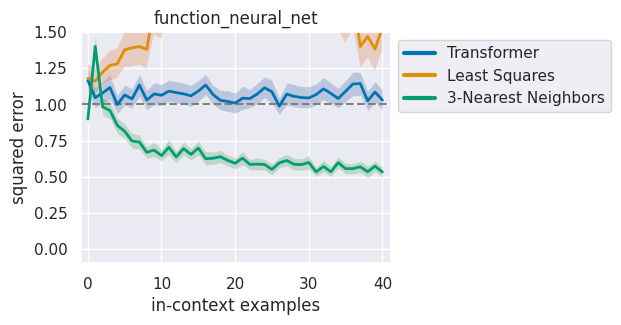

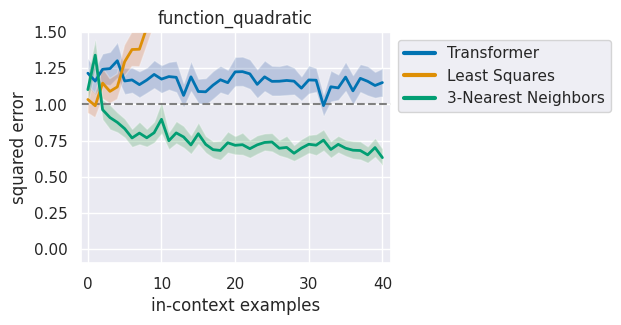

In [33]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue

    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)

    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [34]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [35]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [36]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [37]:
with torch.no_grad():
    pred = model(xs, ys)

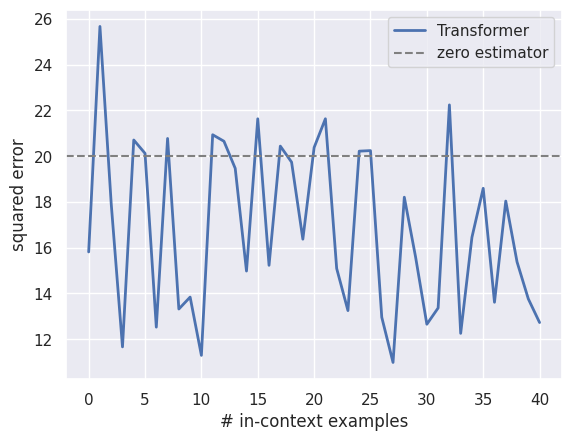

In [38]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "mixed_function": n_dims,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [39]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

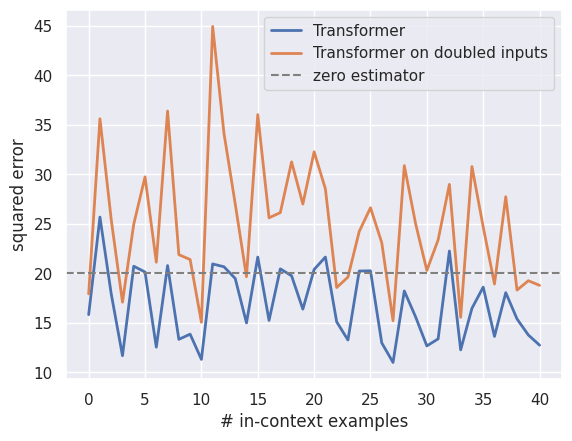

In [40]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.